<a href="https://colab.research.google.com/github/NP-15/Machine-learning/blob/main/Sessions/PCA_t-SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

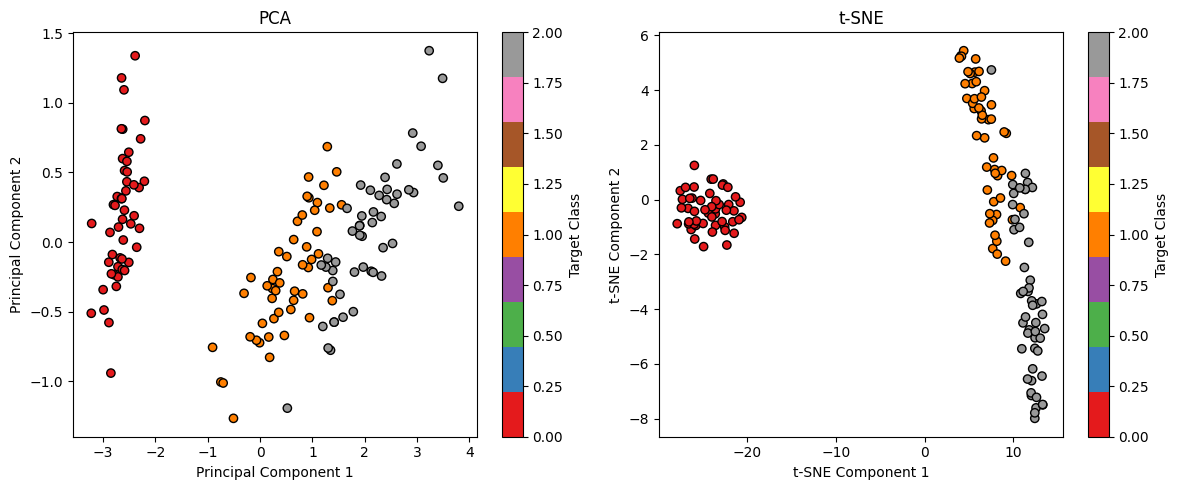

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Target Class')

plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.title('t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Target Class')

plt.tight_layout()
plt.show()


## PCA

In [3]:
import numpy as np

def pca(X=np.array([]), no_dims=50):
    """
    Runs PCA on the NxD array X in order to reduce its dimensionality to
    no_dims dimensions.
    """
    print("Preprocessing the data using PCA...")
    (n, d) = X.shape

    X = X - np.tile(np.mean(X, 0), (n, 1))

    cov_matrix = np.dot(X.T, X)

    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    sorted_indices = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    M = eigenvectors[:, 0:no_dims]

    Y = np.dot(X, M)

    return Y

In [4]:
  from sklearn.datasets import load_iris

  iris = load_iris()
  X = iris.data
  reduced_data = pca(X, no_dims=2)

  print("PCA applied successfully.")
  print("Reduced data shape:", reduced_data.shape)

Preprocessing the data using PCA...
PCA applied successfully.
Reduced data shape: (150, 2)


## t-SNE

In [9]:
import numpy as np

def x2p(X, tol=1e-5, perplexity=30.0):
    """
    Computes pairwise affinities of the data X using the t-SNE perplexity.
    """
    sum_X = np.sum(np.square(X), axis=1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros_like(D)
    n = X.shape[0]

    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    for i in range(n):

        beta_min = -np.inf
        beta_max = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]

        H, thisP = Hbeta(Di, beta[i])

        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            if Hdiff > 0:
                beta_min = beta[i]
                if beta_max == np.inf or beta_max == -np.inf:
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + beta_max) / 2
            else:
                beta_max = beta[i]
                if beta_min == np.inf or beta_min == -np.inf:
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + beta_min) / 2

            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    return P

def Hbeta(D, beta):
    """
    Given a vector of pairwise distances, return the Gaussian kernel
    values and the perplexity of the distribution.
    """
    P = np.exp(-D.copy() * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
    Runs t-SNE on the dataset in the NxD array X to reduce its
    dimensionality to no_dims dimensions. The syntaxis of the function is
    `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.
    P = np.maximum(P, 1e-12)

    for iter in range(max_iter):

        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        if iter == 100:
            P = P / 4.

    return Y


In [10]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data

reduced_data = tsne(X, no_dims=2)
print("t-SNE applied successfully.")
print("Reduced data shape:", reduced_data.shape)

Preprocessing the data using PCA...
Iteration 10: error is 11.254554
Iteration 20: error is 9.238712
Iteration 30: error is 10.077189
Iteration 40: error is 10.071540
Iteration 50: error is 10.089544
Iteration 60: error is 10.081855
Iteration 70: error is 10.286952
Iteration 80: error is 10.166811
Iteration 90: error is 10.378924
Iteration 100: error is 10.002630
Iteration 110: error is 1.256060
Iteration 120: error is 0.740318
Iteration 130: error is 0.473546
Iteration 140: error is 0.368287
Iteration 150: error is 0.296564
Iteration 160: error is 0.249187
Iteration 170: error is 0.198210
Iteration 180: error is 0.191162
Iteration 190: error is 0.184714
Iteration 200: error is 0.181046
Iteration 210: error is 0.179888
Iteration 220: error is 0.179251
Iteration 230: error is 0.178612
Iteration 240: error is 0.178022
Iteration 250: error is 0.177473
Iteration 260: error is 0.176925
Iteration 270: error is 0.176457
Iteration 280: error is 0.176017
Iteration 290: error is 0.175626
Iterati